In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

In [2]:
data = pd.read_csv("data.csv")
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
data_withoutcountry = data.drop(['country'], axis = 1)
data_withoutcountry.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


<Axes: >

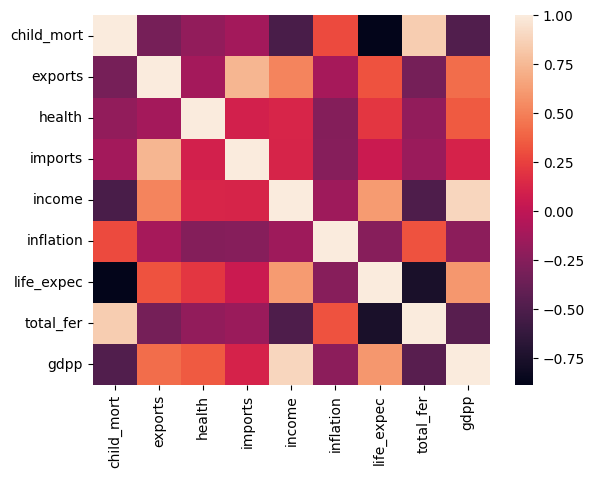

In [5]:
correlation_matrix = data_withoutcountry.corr()
sns.heatmap(correlation_matrix)

In [6]:
data_standardized = (data_withoutcountry - data_withoutcountry.mean()) / data_withoutcountry.std()
data_standardized.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.287660,-1.134867,0.278251,-0.082208,-0.805822,0.156864,-1.614237,1.897176,-0.677143
1,-0.537333,-0.478220,-0.096725,0.070624,-0.374243,-0.311411,0.645924,-0.857394,-0.484167
2,-0.272015,-0.098824,-0.963176,-0.639838,-0.220182,0.786908,0.668413,-0.038289,-0.463980
3,2.001787,0.773056,-1.443729,-0.164820,-0.583289,1.382894,-1.175698,2.121770,-0.514720
4,-0.693548,0.160186,-0.286034,0.496076,0.101427,-0.599944,0.702147,-0.540321,-0.041692


In [7]:
'''
covariance_matrix = np.cov(data_standardized.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[indices]
eigenvectors = eigenvectors[indices]
eigenvectors = eigenvectors[:,:2]
'''

'\ncovariance_matrix = np.cov(data_standardized.T)\neigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)\nindices = np.argsort(eigenvalues)[::-1]\neigenvalues = eigenvalues[indices]\neigenvectors = eigenvectors[indices]\neigenvectors = eigenvectors[:,:2]\n'

In [9]:
class KMeansClustering:
    def __init__(self, data, k, max_iterations=100):
        self.data = np.array(data)
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels = None
        self.eigenvectors = None
        self.n_samples = self.data.shape[0]

    def random_centroids(self, data):
        centroids = []
        for i in range(self.k):
            centroid = data.sample(n=1).iloc[0]
            centroids.append(centroid)
        return pd.concat(centroids, axis=1)

    def get_labels(self, data, centroids):
        distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
        return distances.idxmin(axis=1)

    def new_centroids(self, data, labels):
        centroids = data.groupby(labels).mean().T
        return centroids

    def calculate_pca(self, data):
        covariance_matrix = np.cov(data.T)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvectors = eigenvectors[:, :2]

    def fit(self, data):
        self.calculate_pca(data)
        centroids = self.random_centroids(data)
        old_centroids = pd.DataFrame()
        iteration = 1
        while iteration < self.max_iterations and not centroids.equals(old_centroids):
            old_centroids = centroids
            self.labels = self.get_labels(data, centroids)
            centroids = self.new_centroids(data, self.labels)
            self.plot_clusters(data, self.labels, centroids, iteration)
            iteration += 1
        self.centroids = centroids

    def silhouette_score(self):
        silhouette_scores = []
        for i in range(self.n_samples):
            own_cluster = self.labels[i]
            own_cluster_points = self.data[self.labels == own_cluster]
            a = np.mean(np.linalg.norm(own_cluster_points - self.data[i], axis=1))
            b = min(np.mean(np.linalg.norm(self.data[self.labels == cluster] - self.data[i], axis=1)) for cluster in np.unique(self.labels) if cluster != own_cluster)
            s = (b - a) / max(a, b)
            silhouette_scores.append(s)
        return np.mean(silhouette_scores)

    def plot_clusters(self, data, labels, centroids, iteration):
        reduced_data = np.dot(data, self.eigenvectors)
        reduced_centroids = np.dot(centroids.T, self.eigenvectors)
        plt.figure(figsize=(10, 10))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
        plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X')
        plt.title(f"Iteration {iteration}")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()


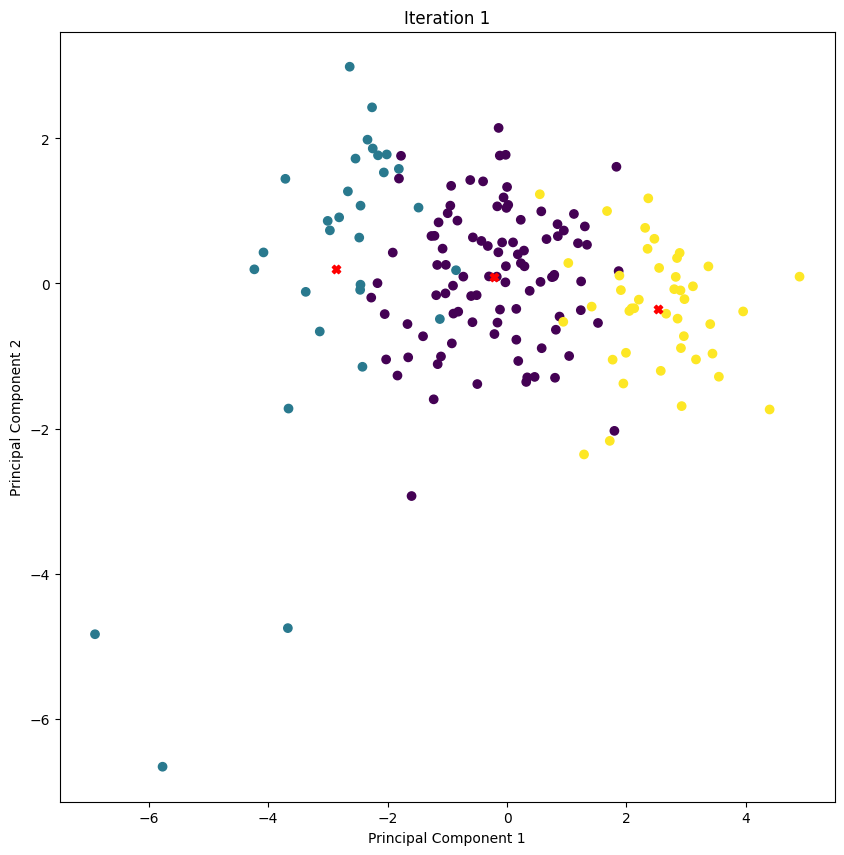

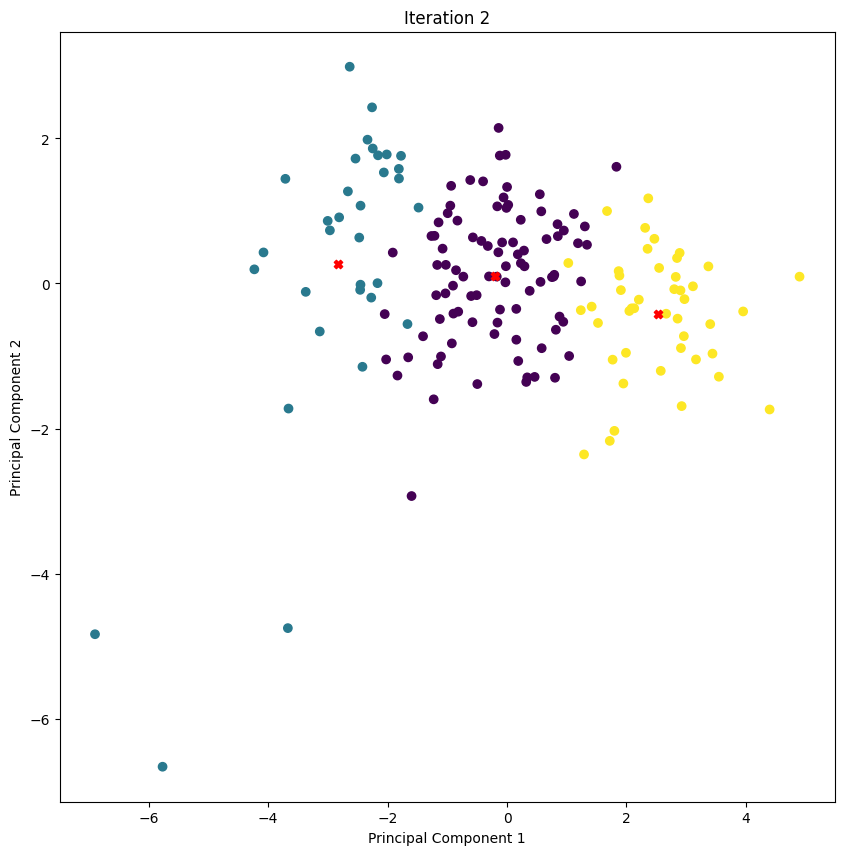

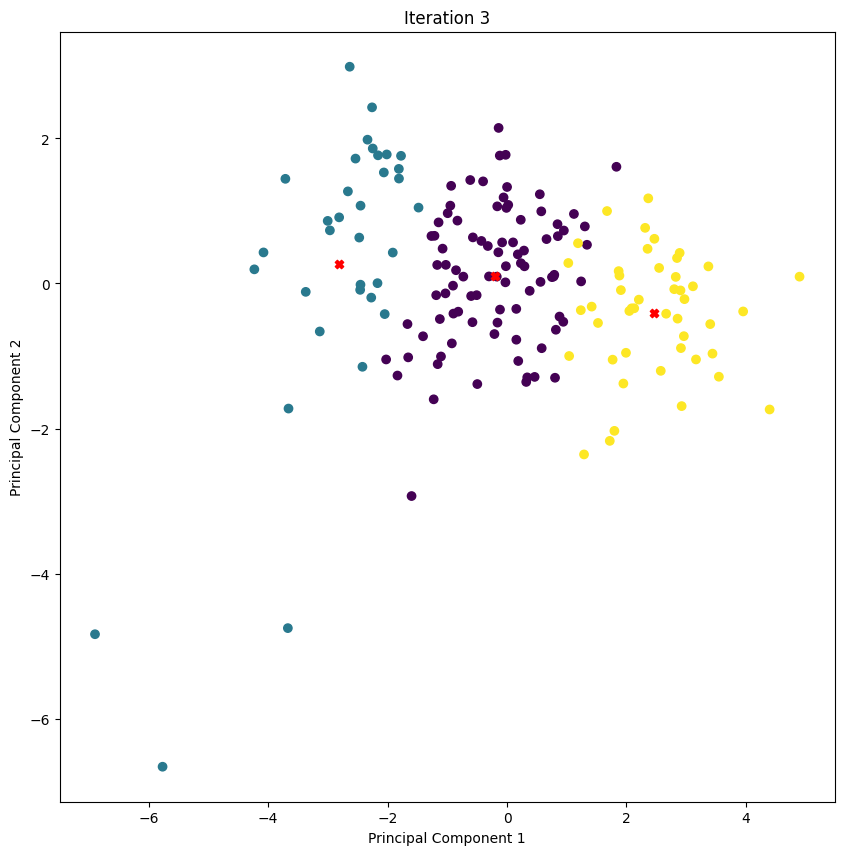

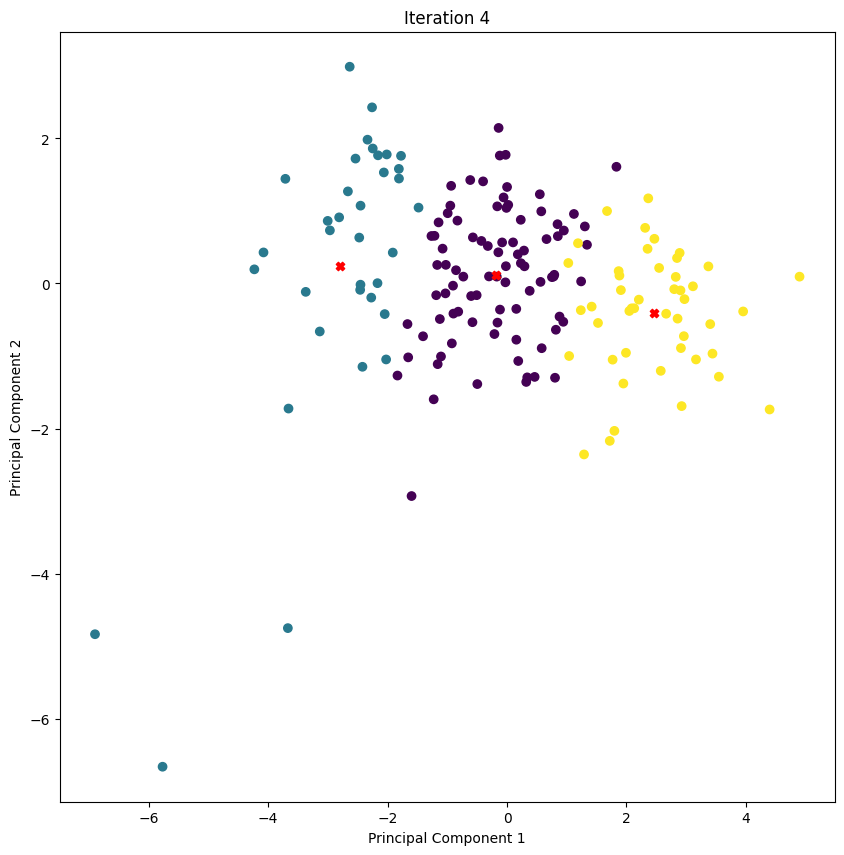

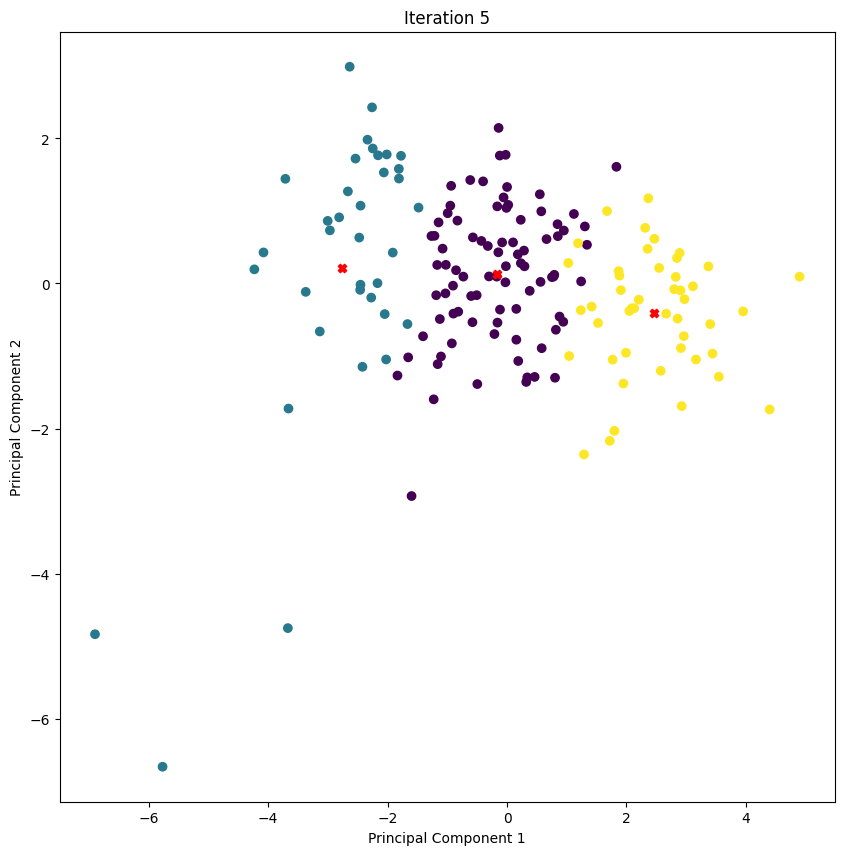

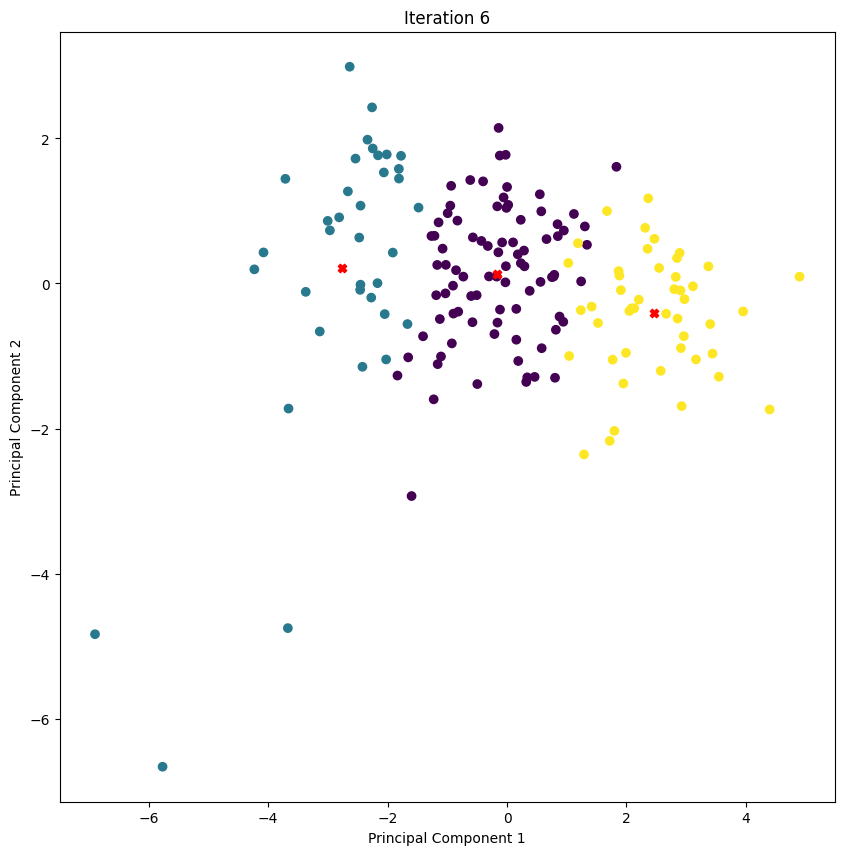

0.29754246629096204

In [10]:
kmeans = KMeansClustering(data_standardized, k=3)
kmeans.fit(data_standardized)
Y_kmeans = kmeans.labels
kmeans.silhouette_score()

In [19]:
class AgglomerativeHierarchicalClustering:
    def __init__(self, data, n_clusters):
        self.data = np.array(data)
        self.n_samples = self.data.shape[0]
        self.n_clusters = n_clusters
        self.labels = np.arange(self.n_samples)
        self.eigenvectors = None

    def calculate_pca(self, data):
        covariance_matrix = np.cov(data.T)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, indices]
        self.eigenvectors = eigenvectors[:, :2]

    def aver_linkage_distance(self, cluster_A, cluster_B):
        distance = 0
        for i in range(len(cluster_A)):
            distance += np.linalg.norm(cluster_B - cluster_A[i, :], axis=1).sum()
        distance /= (len(cluster_A) * len(cluster_B))
        return distance

    def calculate_distance(self, cluster_A, cluster_B):
            return np.min([np.linalg.norm(a - b) for a in cluster_A for b in cluster_B])

    def pairwise_distance(self):
        distance_matrix = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            for j in range(i + 1, self.n_samples):
                distance = np.linalg.norm(self.data[i] - self.data[j])
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance
        return distance_matrix

    def update(self, distance_matrix, labels):
        idx_upper = np.triu_indices(len(distance_matrix), k=1)
        min_value_idx = np.argmin(distance_matrix[idx_upper])
        row, col = np.unravel_index(min_value_idx, distance_matrix.shape)
        labels[labels == col] = row
        labels[labels > col] -= 1
        distance_matrix = np.delete(distance_matrix, col, 0)
        distance_matrix = np.delete(distance_matrix, col, 1)
        for i in range(len(distance_matrix)):
            if i != row:
                cluster_A = self.data[labels == row]
                cluster_B = self.data[labels == i]
                distance_matrix[row, i] = self.calculate_distance(cluster_A, cluster_B)
                distance_matrix[i, row] = distance_matrix[row, i]
        return distance_matrix, labels

    def fit(self):
        distance_matrix = self.pairwise_distance()
        while len(np.unique(self.labels)) > self.n_clusters:
            distance_matrix, self.labels = self.update(distance_matrix, self.labels)

    def get_clusters(self):
        clusters = {}
        for label in np.unique(self.labels):
            clusters[label] = self.data[self.labels == label]
        return clusters
        
    def silhouette_score(self):
        silhouette_scores = []
        for i in range(self.n_samples):
            own_cluster = self.labels[i]
            own_cluster_points = self.data[self.labels == own_cluster]
            a = np.mean(np.linalg.norm(own_cluster_points - self.data[i], axis=1))
            b = min(np.mean(np.linalg.norm(self.data[self.labels == cluster] - self.data[i], axis=1)) for cluster in np.unique(self.labels) if cluster != own_cluster)
            s = (b - a) / max(a, b)
            silhouette_scores.append(s)
        return np.mean(silhouette_scores)
      
    def plot_clusters(self, data):
        reduced_data = np.dot(data, self.eigenvectors)
        cluster_ids = np.unique(self.labels)
        plt.figure(figsize=(10, 10))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=self.labels, cmap='viridis')
        plt.title("Hierarchical Clustering")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()



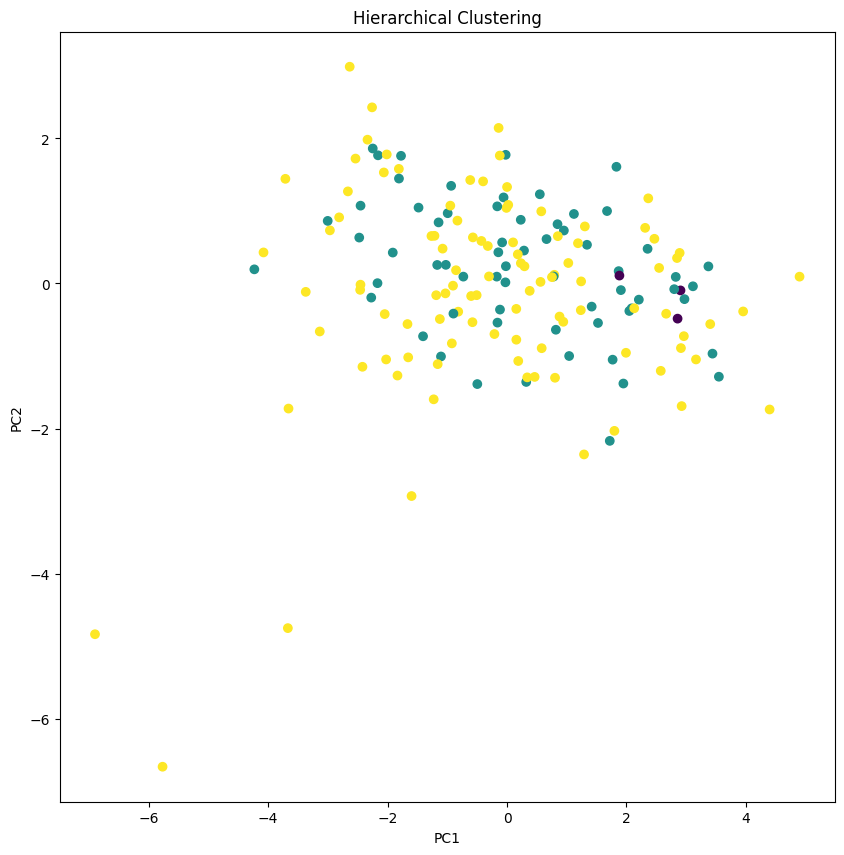

-0.11090122737173515


In [20]:
hierarchical = AgglomerativeHierarchicalClustering(data_standardized, n_clusters=3)
hierarchical.calculate_pca(np.array(data_standardized))
hierarchical.fit()
hierarchical.plot_clusters(np.array(data_standardized))
print(hierarchical.silhouette_score())
Y_hierarchical = hierarchical.labels

In [13]:
print(Y_kmeans.shape)
print(Y_hierarchical.shape)

(167,)
(167,)


In [14]:
# Calculate split index
split_percent = int(len(data_standardized) * 0.9)

X_train = data_standardized[:split_percent].values
X_test = data_standardized[split_percent:].values
y_train_kmeans = Y_kmeans[:split_percent].values
y_test_kmeans = Y_kmeans[split_percent:].values
y_train_hierarchical = Y_hierarchical[:split_percent]
y_test_hierarchical = Y_hierarchical[split_percent:]

print(X_train.shape)
print(X_test.shape)
print(y_train_kmeans.shape)
print(y_test_kmeans.shape)
print(y_train_hierarchical.shape)
print(y_test_hierarchical.shape)


(150, 9)
(17, 9)
(150,)
(17,)
(150,)
(17,)


In [15]:
y_train_kmeans = y_train_kmeans.reshape(len(X_train), 1)
y_test_kmeans = y_test_kmeans.reshape(len(X_test), 1)
y_train_hierarchical = y_train_hierarchical.reshape(len(X_train), 1)
y_test_hierarchical = y_test_hierarchical.reshape(len(X_test), 1)

In [30]:
class KNN:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            nearest_neighbors = np.argsort(distances)[:self.k]
            labels, counts = np.unique(self.y_train[nearest_neighbors], return_counts=True)
            predictions.append(labels[np.argmax(counts)])
        return np.array(predictions)

    def accuracy(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)
        return accuracy


In [31]:
knn_kmeans = KNN(k=3)
knn_kmeans.fit(X_train, y_train_kmeans)
y_pred_kmeans = knn_kmeans.predict(X_test)
accuracy_kmeans = knn_kmeans.accuracy(y_test_kmeans, y_pred_kmeans)
print("KNN Accuracy:", accuracy_kmeans)

KNN Accuracy: 0.43252595155709345


In [22]:
knn_hierarchical = KNN(k=3)
knn_hierarchical.fit(X_train, y_train_hierarchical)
y_pred_hierarchical = knn_hierarchical.predict(X_test)
accuracy_hierarchical = knn_hierarchical.accuracy(y_test_hierarchical, y_pred_hierarchical)
print("KNN Accuracy:", accuracy_hierarchical)

KNN Accuracy: 0.671280276816609
